# Exploratory Data Analysis

In [4]:
import time
import torch
import random
import numpy as np

from torch import nn, Tensor
from torch.utils.data import DataLoader

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt
from matplotlib import cm


# minari dataset
import minari

# To avoide meshgrid warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')

if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)

Using cpu.


In [5]:
def get_dataset_stats(dataset):
    loader = DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)
    
    all_obs, all_act = [], []
    for batch in loader:
        for i in range(batch['observations'].shape[0]):
            length = batch['episode_lengths'][i]
            all_obs.append(batch['observations'][i, :length])
            all_act.append(batch['actions'][i, :length])

    flat_obs = torch.cat(all_obs, dim=0)
    flat_act = torch.cat(all_act, dim=0)

    stats = {
        "obs_mean": torch.mean(flat_obs, dim=0),
        "obs_std": torch.std(flat_obs, dim=0),
        "act_mean": torch.mean(flat_act, dim=0),
        "act_std": torch.std(flat_act, dim=0)
    }
    # Add a small epsilon to prevent division by zero
    stats["obs_std"][stats["obs_std"] < 1e-6] = 1e-6
    stats["act_std"][stats["act_std"] < 1e-6] = 1e-6
    print("Statistics calculation complete.")
    return stats



## Some Basic Dataset Statistics


In [7]:
def collate_fn(batch):
    observations = [torch.as_tensor(x.observations) for x in batch]
    actions = [torch.as_tensor(x.actions) for x in batch]
    rewards = [torch.as_tensor(x.rewards) for x in batch]
    terminations = [torch.as_tensor(x.terminations) for x in batch]
    truncations = [torch.as_tensor(x.truncations) for x in batch]
    episode_lengths = torch.tensor([len(x.actions) for x in batch], dtype=torch.long)

    return {
        "id": torch.Tensor([x.id for x in batch]),
        "observations": torch.nn.utils.rnn.pad_sequence(
            observations,
            batch_first=True
        ),
        "actions": torch.nn.utils.rnn.pad_sequence(
            actions,
            batch_first=True
        ),
        "rewards": torch.nn.utils.rnn.pad_sequence(
            rewards,
            batch_first=True
        ),
        "terminations": torch.nn.utils.rnn.pad_sequence(
            terminations,
            batch_first=True
        ),
        "truncations": torch.nn.utils.rnn.pad_sequence(
            truncations,
            batch_first=True
        ),
        "episode_lengths": episode_lengths
    }

Statistics calculation complete.


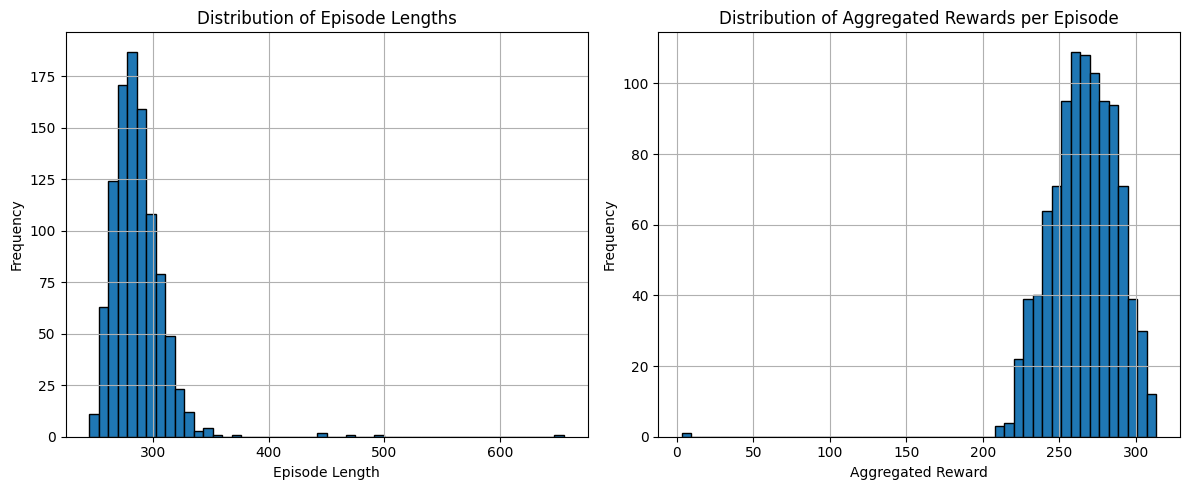

Total number of episodes: 1000
Average episode length: 286.24
Min episode length: 245
Max episode length: 655
Average aggregated reward: 265.91
Min aggregated reward: 3.29
Max aggregated reward: 313.31


{'obs_mean': tensor([-3.8224e-03,  4.5600e-01, -1.2215e-02, -2.1999e-01,  8.3548e-03,
          5.4869e-05,  1.5350e-01,  1.5069e-01]),
 'obs_std': tensor([0.1204, 0.4510, 0.1873, 0.1716, 0.1091, 0.0863, 0.3605, 0.3577]),
 'act_mean': tensor([-0.0279,  0.0534]),
 'act_std': tensor([0.5133, 0.3983])}

In [8]:
horizon = 100
obs_dim = 8
action_dim = 2
dataset_name = "LunarLanderContinuous-v3/ppo-1000-deterministic-v1"
def visualize_chunk(ax, chunk, color, x_limits=(-0.4, 0.4), y_limits=(-0.2, 1.5), mode='line'):
    # make sure chunk is horizon x obs_dim
    assert chunk.shape == (horizon , obs_dim,)
    x = chunk[:, 0].cpu().numpy()
    y = chunk[:, 1].cpu().numpy()
    if mode == 'line':
        ax.plot(x, y, linestyle='-', color=color, alpha=0.7)
    elif mode == 'scatter':
        ax.scatter(x, y, color=color, alpha=0.7)
    ax.set_xlim(*x_limits)
    ax.set_ylim(*y_limits)
    ax.grid(True)

def visualize_dataset(dataset):
    episode_lengths = []
    aggregated_rewards = []

    for eps in dataset.episode_indices:
        episode = dataset[eps]
        episode_lengths.append(episode.observations.shape[0])    
        aggregated_rewards.append(np.sum(episode.rewards))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(episode_lengths, bins=50, edgecolor='black')
    plt.title('Distribution of Episode Lengths')
    plt.xlabel('Episode Length')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(aggregated_rewards, bins=50, edgecolor='black')
    plt.title('Distribution of Aggregated Rewards per Episode')
    plt.xlabel('Aggregated Reward')
    plt.ylabel('Frequency')
    plt.grid(True)


    plt.tight_layout()
    plt.show()

    print(f"Total number of episodes: {len(episode_lengths)}")
    print(f"Average episode length: {np.mean(episode_lengths):.2f}")
    print(f"Min episode length: {np.min(episode_lengths)}")
    print(f"Max episode length: {np.max(episode_lengths)}")
    print(f"Average aggregated reward: {np.mean(aggregated_rewards):.2f}")
    print(f"Min aggregated reward: {np.min(aggregated_rewards):.2f}")
    print(f"Max aggregated reward: {np.max(aggregated_rewards):.2f}")

minari_dataset = minari.load_dataset(dataset_id=dataset_name)
minari_dataset_stats = get_dataset_stats(minari_dataset)
visualize_dataset(minari_dataset)
minari_dataset_stats


## Data Preprocessing
Our dataset is made of 1000 episodes, with each episode containing a variable number of timsteps.
This section is used to create chunks of trajectories with the specified horizon length.
1. Normalization and Unnormalization: We need to normalize the chunks before training and unnormalize them after training to get the correct trajectories.
2. The collate function is used to pad the sequence to the same length within a batch when we load it using a DataLoader.

In [9]:
def create_trajectory_chunks(batch, horizon):
    """
    Processes a padded batch to create fixed-size trajectory chunks.
    """
    batch_size = batch['observations'].shape[0]
    all_chunks = []

    for i in range(batch_size):
        # Get the data for one episode and its true length
        obs = batch['observations'][i]      # Shape: (max_len, 8)
        act = batch['actions'][i]          # Shape: (max_len-1, 2)
        length = batch['episode_lengths'][i]       # Scalar, e.g., 495

        # A single episode can produce multiple chunks
        # We slide a window of size 'horizon' over the valid part of the episode
        for start_idx in range(length - horizon + 1):
            end_idx = start_idx + horizon

            # Slice the observation and action sequences to get a chunk
            obs_chunk = obs[start_idx:end_idx] # Shape: (horizon, 8)
            act_chunk = act[start_idx:end_idx] # Shape: (horizon, 2)
            
            # Combine them into a single (horizon, 10) tensor
            chunk = torch.cat([obs_chunk, act_chunk], dim=-1)

            # Flatten the chunk to the final 1000-D vector and add to our list
            all_chunks.append(chunk.flatten())

    if not all_chunks:
        return None

    return torch.stack(all_chunks)

def create_normalized_chunks(batch, horizon, stats):
    obs_mean, obs_std = stats['obs_mean'], stats['obs_std']
    act_mean, act_std = stats['act_mean'], stats['act_std']

    all_chunks = []
    for i in range(batch['observations'].shape[0]):
        obs, act, length = batch['observations'][i], batch['actions'][i], batch['episode_lengths'][i]
        
        if length < horizon:
            continue
            
        for start_idx in range(length - horizon + 1):
            end_idx = start_idx + horizon
            
            obs_chunk = obs[start_idx:end_idx]
            act_chunk = act[start_idx:end_idx]
            
            # apply normalization
            norm_obs_chunk = (obs_chunk - obs_mean) / obs_std
            norm_act_chunk = (act_chunk - act_mean) / act_std

            chunk = torch.cat([norm_obs_chunk, norm_act_chunk], dim=-1)
            all_chunks.append(chunk.flatten())

    if not all_chunks:
        return None
    return torch.stack(all_chunks)


def unnormalize_trajectory(norm_trajectory_chunk, stats, horizon, obs_dim, action_dim):
    obs_mean, obs_std = stats['obs_mean'], stats['obs_std']
    act_mean, act_std = stats['act_mean'], stats['act_std']
    
    # Reshape to (horizon, obs_dim + action_dim)
    reshaped_chunk = norm_trajectory_chunk.reshape(horizon, obs_dim + action_dim)
    
    norm_obs = reshaped_chunk[:, :obs_dim]
    norm_act = reshaped_chunk[:, obs_dim:]
    
    # Apply the reverse transformation: (data * std) + mean
    unnorm_obs = (norm_obs * obs_std) + obs_mean
    unnorm_act = (norm_act * act_std) + act_mean
    
    return unnorm_obs, unnorm_act

## Trajectory Visualization from Expert Dataset

Visualing random chunks from each batch...


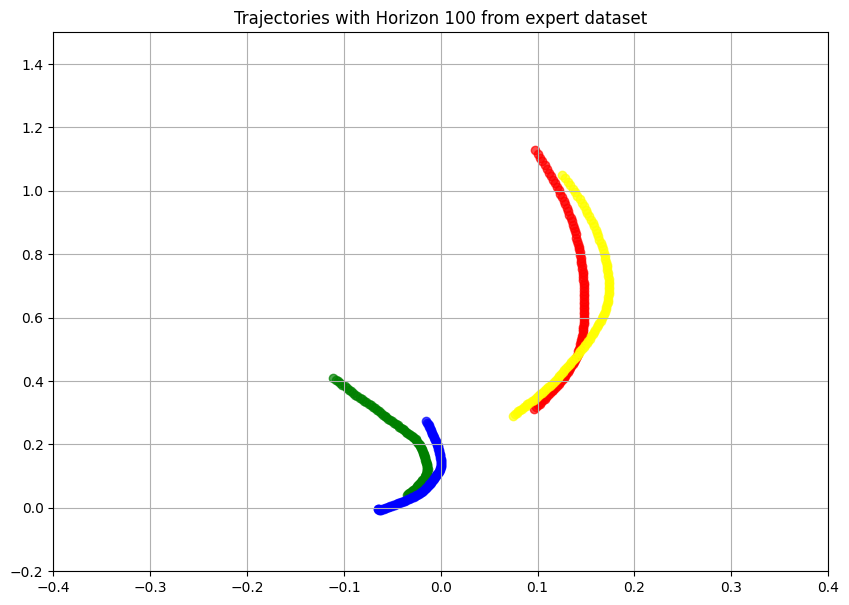

In [67]:
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with Horizon {horizon} from expert dataset')
print("Visualing random chunks from each batch...")
colors = ['red', 'green', 'blue', 'yellow']
for idx, batch in enumerate(dataloader):
    processed_chunks = create_trajectory_chunks(batch, horizon)
    # uncomment to visualize normalized chunks
    # normalized_chunks = create_normalized_chunks(batch, horizon, minari_dataset_stats)
    random_chunk = random.choice(processed_chunks)
    assert random_chunk.shape == (horizon * (obs_dim + action_dim),)
    random_chunk = random_chunk.reshape(horizon, obs_dim + action_dim)
    expert_obs = random_chunk[:, :obs_dim]
    visualize_chunk(ax, expert_obs, color=colors[idx % len(colors)], mode="scatter")

# Training

## Model Architecture
Let's start with a basic MLP.

In [11]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x


# TODO: need to resolve temporal locality problem maybe with a CNN later.
class MLP(nn.Module):
    def __init__(self, input_dim: int, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()

        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim + time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)

        return output.reshape(*sz)

## Overfitting Sanity Check ✅
Let's do a sanity check first on one chunk of the dataset with horizon length 10.

In [83]:
from src.utils.loggers import WandBLogger

# training parameters
horizon = 10
input_dim = (obs_dim + action_dim) * horizon
dataloader = DataLoader(
    minari_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
batch = next(iter(dataloader))
normalized_chunks = create_normalized_chunks(batch, horizon, minari_dataset_stats)
expert_chunk_to_overfit = normalized_chunks[0].to(device)
assert expert_chunk_to_overfit.shape == (horizon * (obs_dim + action_dim),)

# hyperparameters
lr = 1e-4
num_epochs = 1000000
print_every = 100
hidden_dim = 256

config = {
    "horizon": horizon,
    "action_dim": action_dim,
    "obs_dim": obs_dim,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_epochs": num_epochs,
    "lr": lr,
}

logger = WandBLogger(config=config)
vf = MLP(input_dim=input_dim, time_dim=1, hidden_dim=hidden_dim).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)

print("Overfitting to a single chunk...")
running_loss = 0.0
for i in range(num_epochs):
    optim.zero_grad()

    x_1 = expert_chunk_to_overfit.unsqueeze(0)
    x_0 = torch.randn_like(x_1).to(device)
    t = torch.rand(x_1.shape[0]).to(device)

    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    predicted_velocity = vf(path_sample.x_t, path_sample.t)
    loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

    loss.backward()
    optim.step()

    running_loss += loss.item()
    if (i + 1) % print_every == 0:
        avg_loss = running_loss / print_every
        print(f"Iteration {i+1:6d}: Avg Loss = {avg_loss:8.5f}")
        logger.log({"avg_loss": avg_loss})
        running_loss = 0.0

avg_loss,████▇▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁
avg_loss,0.47464


Overfitting to a single chunk...
Iteration    100: Avg Loss =  2.49297
Iteration    200: Avg Loss =  1.42179
Iteration    300: Avg Loss =  1.19187
Iteration    400: Avg Loss =  1.12259
Iteration    500: Avg Loss =  1.07674
Iteration    600: Avg Loss =  0.99779
Iteration    700: Avg Loss =  1.04858
Iteration    800: Avg Loss =  1.03489
Iteration    900: Avg Loss =  1.02929
Iteration   1000: Avg Loss =  1.05062
Iteration   1100: Avg Loss =  1.06307
Iteration   1200: Avg Loss =  0.99657
Iteration   1300: Avg Loss =  1.02206
Iteration   1400: Avg Loss =  1.01728
Iteration   1500: Avg Loss =  1.03604
Iteration   1600: Avg Loss =  0.99238
Iteration   1700: Avg Loss =  1.03139
Iteration   1800: Avg Loss =  1.02728
Iteration   1900: Avg Loss =  1.02039
Iteration   2000: Avg Loss =  1.01020
Iteration   2100: Avg Loss =  1.02218
Iteration   2200: Avg Loss =  1.00735
Iteration   2300: Avg Loss =  0.98548
Iteration   2400: Avg Loss =  1.00875
Iteration   2500: Avg Loss =  1.02233
Iteration   2600:

## Sanity Check with Only Observations 👀

In [146]:
def get_xy_dataset_stats(dataset):
    """Computes mean and std for ONLY the X and Y dimensions."""
    print("Calculating X,Y dataset statistics...")
    loader = DataLoader(dataset, batch_size=512, shuffle=False, collate_fn=collate_fn)
    all_obs = []
    for batch in loader:
        for i in range(batch['observations'].shape[0]):
            length = batch['episode_lengths'][i]
            all_obs.append(batch['observations'][i, :length, :2]) # Slice for only X and Y

    flat_obs = torch.cat(all_obs, dim=0)
    stats = {"xy_mean": torch.mean(flat_obs, dim=0), "xy_std": torch.std(flat_obs, dim=0)}
    stats["xy_std"][stats["xy_std"] < 1e-6] = 1e-6
    print("Statistics calculation complete.")
    return stats

def create_xy_chunks(batch, horizon, stats):
    """Creates normalized, flattened chunks of ONLY X,Y coordinates."""
    xy_mean, xy_std = stats['xy_mean'], stats['xy_std']
    all_chunks = []
    for i in range(batch['observations'].shape[0]):
        # We only need the first 2 columns (x, y) from observations
        obs_xy = batch['observations'][i, :, :2]
        length = batch['episode_lengths'][i]
        
        if length < horizon: continue
        for start_idx in range(length - horizon + 1):
            end_idx = start_idx + horizon
            xy_chunk = obs_xy[start_idx:end_idx]
            
            norm_xy_chunk = (xy_chunk - xy_mean) / xy_std
            all_chunks.append(norm_xy_chunk.flatten())
            
    if not all_chunks: return None
    return torch.stack(all_chunks)

def unnormalize_xy_trajectory(norm_xy_chunk, stats, horizon):
    """Un-normalizes an X,Y-only trajectory chunk."""
    xy_mean, xy_std = stats['xy_mean'], stats['xy_std']
    reshaped_chunk = norm_xy_chunk.reshape(horizon, 2) # Reshape to (horizon, 2)
    unnorm_xy = (reshaped_chunk * xy_std) + xy_mean
    return unnorm_xy


# Setup parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
horizon = 100
input_dim = horizon * 2  # The new, simpler input dimension
hidden_dim = 256
lr = 1e-4
iterations = 20000 # A reasonable number of iterations for this simpler task
log_interval = 1000

# load the dataset and compute stats
minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
dataset_stats = get_xy_dataset_stats(minari_dataset)
for k, v in dataset_stats.items(): dataset_stats[k] = v.to(device)
dataloader = DataLoader(minari_dataset, batch_size=512, shuffle=True, collate_fn=collate_fn)

Calculating X,Y dataset statistics...
Statistics calculation complete.


## Actual Training 🏋️
Sanity test passed. Let's go ahead and train the model on the entire dataset.

In [39]:
from src.utils.loggers import WandBLogger

env = minari_dataset.recover_environment()
horizon = 100
action_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
input_dim = (obs_dim + action_dim) * horizon
minari_dataset_stats = get_dataset_stats(minari_dataset)
print(f"Horizon: {horizon}")
print(f"Action Dim: {action_dim}")
print(f"Observation Dim: {obs_dim}")
print(f"Input Dim: {input_dim}")
print("Dataset Stats:")
for k, v in minari_dataset_stats.items():
    print(f"  {k}: {v}")

# Training params
lr = 0.001
num_epochs = 100
print_every = 10
hidden_dim = 256

config = {
    "horizon": horizon,
    "action_dim": action_dim,
    "obs_dim": obs_dim,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_epochs": num_epochs,
    "lr": lr
}

logger = WandBLogger(config = config)
vf = MLP(input_dim=input_dim, time_dim=1, hidden_dim=hidden_dim).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)

print("Starting training...")
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    total_chunks = 0
    start_time = time.time()

    for batch in dataloader:
        optim.zero_grad()
        
        x_1 = create_normalized_chunks(batch, horizon, minari_dataset_stats)
        if x_1 is None:
            continue
        x_1 = x_1.to(device)
        x_0 = torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0]).to(device)

        # 3. Forward pass and Loss
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        predicted_velocity = vf(path_sample.x_t, path_sample.t)
        loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

        # 4. Backward pass and Optimize
        loss.backward()
        optim.step()
        total_epoch_loss += loss.item()
        total_chunks += 1

    avg_epoch_loss = total_epoch_loss / total_chunks if total_chunks > 0 else 0
    logger.log({"avg_epoch_loss": avg_epoch_loss})
    if (epoch + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f"| Epoch {epoch+1:6d} | {elapsed:.2f} s/epoch | Loss {avg_epoch_loss:8.5f} ")
        start_time = time.time()
print("Training finished.")

Statistics calculation complete.
Horizon: 100
Action Dim: 2
Observation Dim: 8
Input Dim: 1000
Dataset Stats:
  obs_mean: tensor([-3.8224e-03,  4.5600e-01, -1.2215e-02, -2.1999e-01,  8.3548e-03,
         5.4869e-05,  1.5350e-01,  1.5069e-01])
  obs_std: tensor([0.1204, 0.4510, 0.1873, 0.1716, 0.1091, 0.0863, 0.3605, 0.3577])
  act_mean: tensor([-0.0279,  0.0534])
  act_std: tensor([0.5133, 0.3983])


avg_epoch_loss,█▇▅▄▃▂▂▁▁▁
avg_epoch_loss,1.22209


Starting training...
| Epoch      1 | 6.27 s/epoch | Loss  1.70227 
| Epoch      2 | 5.86 s/epoch | Loss  1.63010 
| Epoch      3 | 5.93 s/epoch | Loss  1.48838 
| Epoch      4 | 5.85 s/epoch | Loss  1.38666 
| Epoch      5 | 6.05 s/epoch | Loss  1.32323 
| Epoch      6 | 5.77 s/epoch | Loss  1.28555 
| Epoch      7 | 5.75 s/epoch | Loss  1.26237 
| Epoch      8 | 5.49 s/epoch | Loss  1.24468 
| Epoch      9 | 5.48 s/epoch | Loss  1.23063 
| Epoch     10 | 5.47 s/epoch | Loss  1.21827 
| Epoch     11 | 5.47 s/epoch | Loss  1.20763 
| Epoch     12 | 5.48 s/epoch | Loss  1.19961 
| Epoch     13 | 5.49 s/epoch | Loss  1.19178 
| Epoch     14 | 5.46 s/epoch | Loss  1.18598 
| Epoch     15 | 5.37 s/epoch | Loss  1.18032 
| Epoch     16 | 5.37 s/epoch | Loss  1.17519 
| Epoch     17 | 5.43 s/epoch | Loss  1.17280 
| Epoch     18 | 5.39 s/epoch | Loss  1.16972 
| Epoch     19 | 5.41 s/epoch | Loss  1.16525 
| Epoch     20 | 5.40 s/epoch | Loss  1.16306 
| Epoch     21 | 5.43 s/epoch | Loss  1

## Sampling

In [ ]:
# try sampling from trained model...
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)


wrapped_vf = WrappedModel(vf)
step_size = 0.05
batch_size = 1  # batch size
T = torch.linspace(0, 1, 10)  # sample times
T = T.to(device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class


def generate_trajectory():
    x_init = torch.randn((batch_size, input_dim), dtype=torch.float32, device=device)
    sol = solver.sample(
        time_grid=T,
        x_init=x_init,
        method="midpoint",
        step_size=step_size,
        return_intermediates=True,
    )
    final_trajectory = sol[-1].reshape(horizon, obs_dim + action_dim)
    
    obs, act = unnormalize_trajectory(
        final_trajectory.flatten(), minari_dataset_stats, horizon, obs_dim, action_dim
    )
    return obs, act


torch.Size([100, 8])

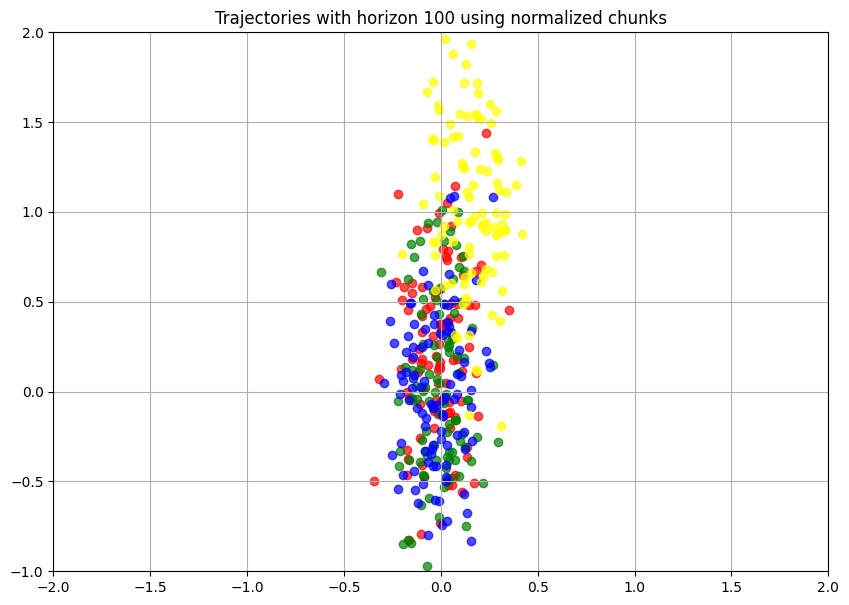

In [71]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with horizon {horizon} using normalized chunks')

# visulizing trajectories
for _ in range(4):
    colors = ['red', 'green', 'blue', 'yellow']
    observations, actions = generate_trajectory()
    assert observations.shape == (horizon, obs_dim)
    visualize_chunk(ax, observations, color=colors[_ % len(colors)],
                    x_limits=(-2, 2), y_limits=(-1, 2), mode='scatter')

# Evaluation

## Our FM Model vs. Random Policy

In [43]:
num_eval_episodes = 100
env = minari_dataset.recover_environment(eval_env = True)
model_rewards = []
random_rewards = []
for eps in range(num_eval_episodes):
    obs, _ = env.reset()
    total_rew = 0
    obs, actions = generate_trajectory()
    for i in range(horizon):
        action = actions[i].cpu().numpy()
        obs, rew, terminated, truncated, info = env.step(action)
        total_rew += rew
        if terminated or truncated:
            break
    model_rewards.append(total_rew)

    env.reset()
    total_rew_random = 0
    for i in range(horizon):
        action = env.action_space.sample()
        obs, rew, terminated, truncated, info = env.step(action)
        total_rew_random += rew
        if terminated or truncated:
            break
    random_rewards.append(total_rew_random)
    if (eps + 1) % 10 == 0:
        print(f"Finished episode {eps + 1}/{num_eval_episodes} - Model Reward: {total_rew}, Random Reward: {total_rew_random}")
env.close()
print("Evaluation finished.")
avg_model_reward = np.mean(model_rewards)
avg_random_reward = np.mean(random_rewards)
print(f"Average Model Reward: {avg_model_reward:.2f}")
print(f"Average Random Reward: {avg_random_reward:.2f}")

Finished episode 10/100 - Model Reward: -276.838369550079, Random Reward: -56.27302687229614
Finished episode 20/100 - Model Reward: -342.6217143928151, Random Reward: -337.6677801116349
Finished episode 30/100 - Model Reward: -691.24486813555, Random Reward: -340.1753987571039
Finished episode 40/100 - Model Reward: -483.7459531247379, Random Reward: -14.773434683038188
Finished episode 50/100 - Model Reward: -240.8642422547829, Random Reward: -181.81549438242962
Finished episode 60/100 - Model Reward: -625.1836026176699, Random Reward: -300.89066621496283
Finished episode 70/100 - Model Reward: -99.1113248504485, Random Reward: -339.12768584928074
Finished episode 80/100 - Model Reward: -248.60084163285592, Random Reward: -310.04164392876396
Finished episode 90/100 - Model Reward: -309.6475727487625, Random Reward: -353.2107985701491
Finished episode 100/100 - Model Reward: -109.38553985253444, Random Reward: -87.8130178557294
Evaluation finished.
Average Model Reward: -266.22
Averag

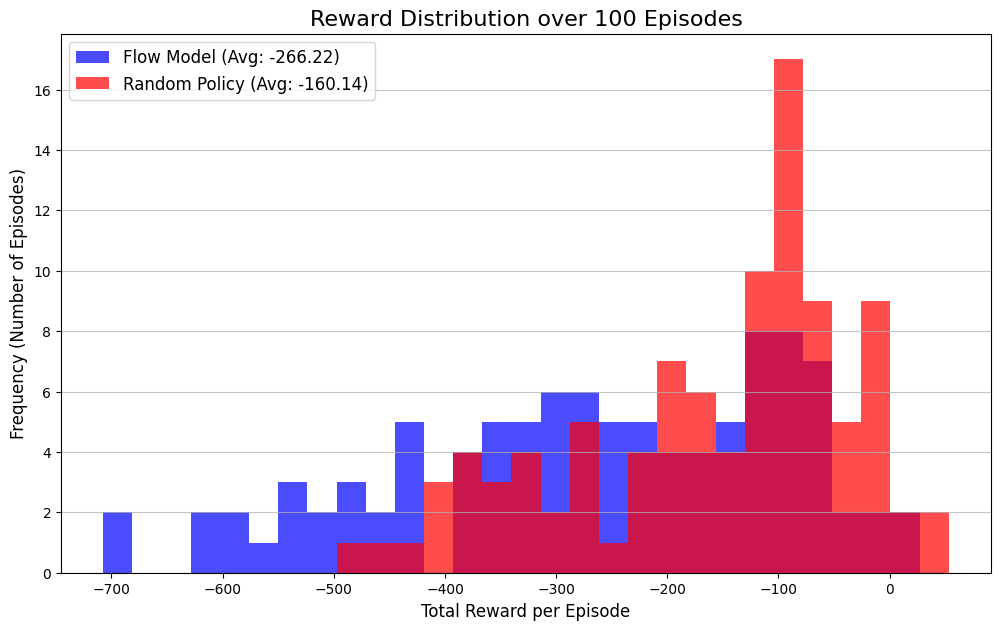

In [56]:
plt.figure(figsize=(12, 7))
# Use a shared range for the bins to make the comparison fair
bins = np.linspace(min(min(model_rewards), min(random_rewards)), max(max(model_rewards), max(random_rewards)), 30)

plt.hist(model_rewards, bins=bins, alpha=0.7, label=f'Flow Model (Avg: {avg_model_reward:.2f})', color='blue')
plt.hist(random_rewards, bins=bins, alpha=0.7, label=f'Random Policy (Avg: {avg_random_reward:.2f})', color='red')

plt.title(f'Reward Distribution over {num_eval_episodes} Episodes', fontsize=16)
plt.xlabel("Total Reward per Episode", fontsize=12)
plt.ylabel("Frequency (Number of Episodes)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

## Rendering the Trajectory

In [62]:

minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
env = minari_dataset.recover_environment(eval_env=True, render_mode="human")

obs, _ = env.reset()
total_rew_random = 0
obs, actions = generate_trajectory()
total_rew = 0
for i in range(horizon):
    action = actions[i].cpu().numpy()
    obs, rew, terminated, truncated, info = env.step(action)
    total_rew += rew
    if terminated or truncated:
        break
env.close()